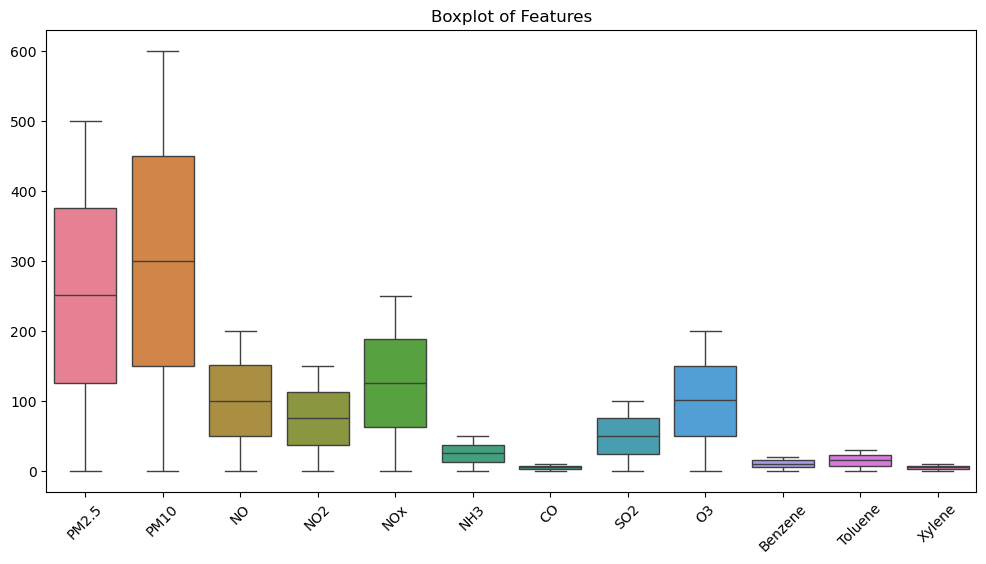


Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Overall Accuracy: 0.3403

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.34      0.34      1239
           1       0.15      0.25      0.19       589
           2       0.49      0.37      0.42      1825

    accuracy                           0.34      3653
   macro avg       0.32      0.32      0.31      3653
weighted avg       0.38      0.34      0.35      3653



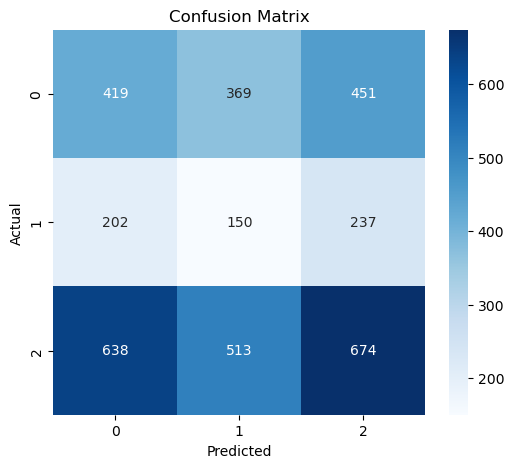


City-wise Accuracy:
        City  Accuracy
0      Delhi  0.871065
1     Mumbai  0.865316
2    Chennai  0.863400
3    Kolkata  0.871065
4  Bangalore  0.869422


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# =============================
# 1️⃣ Load dataset
# =============================
df = pd.read_csv("city_day.csv")  # replace with your CSV path

# =============================
# 2️⃣ Preprocessing
# =============================
# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
#df['AQI_Bucket'].fillna(df['AQI_Bucket'].mode()[0], inplace=True)

# Simplify AQI_Bucket
def bucketize_aqi(x):
    if x in ['Good', 'Satisfactory']:
        return 'Good'
    elif x in ['Moderate']:
        return 'Moderate'
    else:
        return 'Poor'

df['AQI_Bucket'] = df['AQI_Bucket'].apply(bucketize_aqi)

# Encode AQI_Bucket to numeric labels
le = LabelEncoder()
df['AQI_Bucket_Label'] = le.fit_transform(df['AQI_Bucket'])

# =============================
# 3️⃣ Features & Target
# =============================
features = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
target = 'AQI_Bucket_Label'

# =============================
# 4️⃣ EDA (Boxplot)
# =============================
plt.figure(figsize=(12,6))
sns.boxplot(data=df[features])
plt.title("Boxplot of Features")
plt.xticks(rotation=45)
plt.show()

# =============================
# 5️⃣ Train-Test Split
# =============================
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================
# 6️⃣ Feature Scaling
# =============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================
# 7️⃣ Handle Class Imbalance
# =============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# =============================
# 8️⃣ KNN Model + Hyperparameter Tuning
# =============================
param_grid = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform','distance'],
    'p': [1,2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# =============================
# 9️⃣ Evaluation
# =============================
acc = accuracy_score(y_test, y_pred)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Overall Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =============================
# 10️⃣ City-wise Accuracy
# =============================
results = []
for city in df['City'].unique():
    city_data = df[df['City']==city]
    X_city = city_data[features]
    y_city = city_data[target]
    
    X_city_scaled = scaler.transform(X_city)
    y_city_pred = best_knn.predict(X_city_scaled)
    
    acc_city = accuracy_score(y_city, y_city_pred)
    results.append({'City': city, 'Accuracy': acc_city})

results_df = pd.DataFrame(results)
print("\nCity-wise Accuracy:")
print(results_df)
